In [2]:
%load_ext autoreload
%autoreload 1

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

%matplotlib inline

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%aimport toolkit
%aimport util
%aimport workspace_manager

workspace = workspace_manager.WorkspaceManager(
    task_name="counts_to_ase",
    verbose=True
)
workspace.load_workspace(
    requirements = {
        dtype : f"{dtype}.pkl"
        for dtype in ["genome", "counts"]
    }
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data = {
    data_type : util.pickle_load(workspace.tmp_data[data_type])
    for data_type in ["counts", "genome"]
}
data["snp"] = data["counts"]\
                [["CHROM", "POS"]]\
                .to_dense()\
                .astype(np.int64)

/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/pandas/core/generic.py:3607: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  result = self._constructor(new_data).__finalize__(self)
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)


In [7]:
chrom_to_genes = {
    chrom : data["genome"][data["genome"]["CHROM"] == chrom]
    for chrom in data["genome"]["CHROM"].unique()
}

In [9]:
%%time

# Here gene coverage for each phased SNP is computed
# TODO: rewrite this using "bedtools intersect".
# This part doesn't scale well.

def intersect_snp_with_genes(snp_tuple):
    chrom, pos = snp_tuple
    # 1-based to 0-based 
    pos -= 1 # because CellSNP is 1-based, but .bed files are 0-based
    genes_on_chrom = chrom_to_genes[str(chrom)]
    mask = ((genes_on_chrom.START <= pos) 
            & (pos < genes_on_chrom.END))
    return '@'.join(genes_on_chrom[mask].GENE_ID)

pool = mp.Pool(16)
result = pool.map(intersect_snp_with_genes, 
                  tqdm_notebook(data["snp"].values, 
                                "SNP processing"))
pool.close()
pool.join()


CPU times: user 18.9 s, sys: 2.75 s, total: 21.6 s
Wall time: 3min 50s


In [10]:
""" Here the raw results computed in parallel are parsed """
snp_to_genes, gene_to_snps = {}, OrderedDict()

# This way we ensure proper gene ordering
for gene_id in data["genome"].GENE_ID:
    gene_to_snps[gene_id] = []

for i, row in tqdm_notebook(enumerate(data["snp"].values), 
                            "mapping SNPs to genes"):
    chrom, pos = row
    snp = f"{chrom},{pos}"
    snp_to_genes[snp] = result[i].split("@") if result[i] else []
    for gene in snp_to_genes[snp]:
        gene_to_snps[gene].append(snp)

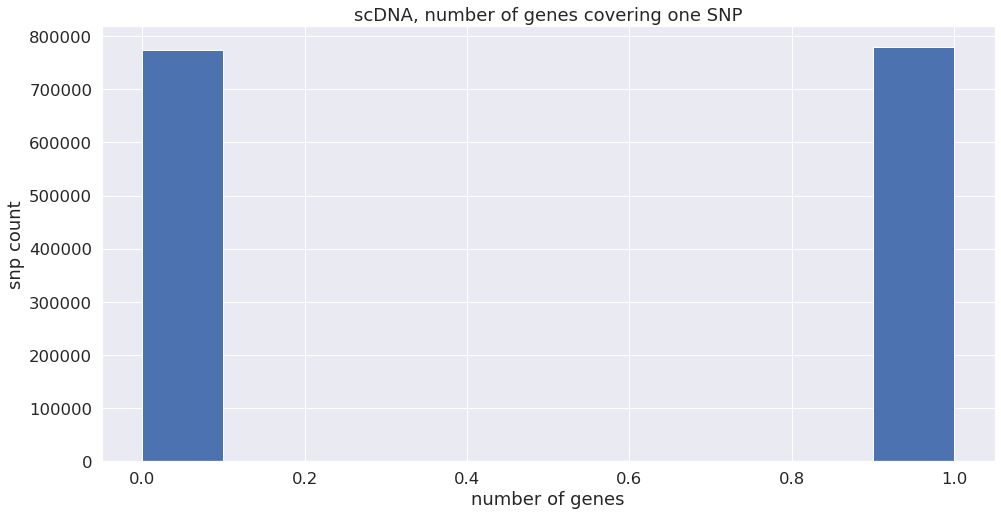

In [11]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.title(f"{workspace.experiment_info['data']}, "
          "number of genes covering one SNP")
plt.xlabel("number of genes")
plt.ylabel("snp count")
plt.hist([len(gene_list) for gene_list in snp_to_genes.values()]);

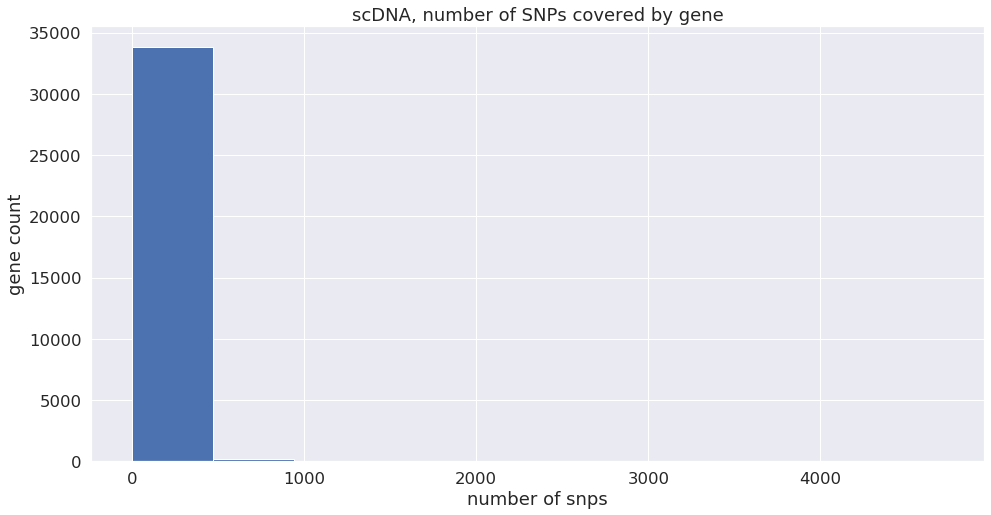

In [12]:
plt.figure(figsize=(16,8))
plt.title(f"{workspace.experiment_info['data']}"
          ", number of SNPs covered by gene")
plt.xlabel("number of snps")
plt.ylabel("gene count")
plt.hist([len(snp_list) for snp_list 
          in gene_to_snps.values()]);

In [30]:
util.pickle_dump(
    snp_to_genes, 
    f"{workspace.tmp_dir}/snp_to_genes.pkl"
)
workspace.add_entry("snp_to_genes", "snp_to_genes.pkl")
util.pickle_dump(
    gene_to_snps, 
    f"{workspace.tmp_dir}/gene_to_snps.pkl"
)
workspace.add_entry("gene_to_snps", "gene_to_snps.pkl")

In [31]:
workspace.status()

Staged for commit: 
	-snp_to_genes : snp_to_genes.pkl
	-gene_counts : gene_counts.pkl
	-gene_to_snps : gene_to_snps.pkl


In [20]:
data["counts"] = util.pickle_load(workspace.tmp_data["counts"])

In [21]:
snp_to_idx = {snp : i for i, snp in 
              tqdm_notebook(enumerate(toolkit.extract_snps(data["counts"])), 
                            "mapping snps to their index numbers "
                            "by position in the genome")}

In [22]:
%%time

gene_to_snp_ids = {gene : np.array([snp_to_idx[snp] for snp in snp_list]) 
                   for gene, snp_list 
                   in tqdm_notebook(gene_to_snps.items(), 
                                    desc="mapping gene to SNP ids"
                                    " (for faster row selection)")}

def extract_gene_counts(barcode):
    gene_to_ad, gene_to_dp = [], []
    # I need to convert these columns to dense format
    # because I need only a subset of rows on each iteration 
    ad = data["counts"][f"{barcode}_ad"].to_dense().values
    dp = data["counts"][f"{barcode}_dp"].to_dense().values
    # gene_to_snps is an OrderedDict, so we can guarantee
    # that all the genes are processed in a correct order
    for gene, snp_ids in gene_to_snp_ids.items():
        if len(snp_ids) > 0:
            ad_sample, dp_sample = ad[snp_ids], dp[snp_ids]
            gene_to_ad.append(np.nan  if np.all(np.isnan(ad_sample)) 
                                      else np.nansum(ad_sample))
            gene_to_dp.append(np.nan  if np.all(np.isnan(dp_sample)) 
                                      else np.nansum(dp_sample))
    return pd.DataFrame({f"{barcode}_ad" : gene_to_ad, 
                         f"{barcode}_dp" : gene_to_dp})

with mp.Pool(16) as pool:
    result_list = pool.map(
        extract_gene_counts, 
        tqdm_notebook(toolkit.extract_barcodes(data["counts"]), 
                      desc="cell_barcode processing")
    )
    
gene_counts_df = pd.concat(result_list, axis=1).to_dense()
gene_counts_df.info()

/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use

/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Columns: 536 entries, AAACCTGTCTTGCGAA-1_ad to TTGGAACGTTCTGTCC-1_dp
dtypes: float64(536)
memory usage: 64.7 MB
CPU times: user 1.11 s, sys: 7.06 s, total: 8.17 s
Wall time: 24.8 s


In [23]:
gene_counts_df.insert(
    0, "GENE_ID", 
    [gene for gene, snp_list 
     in gene_to_snps.items() 
     if len(snp_list) > 0]
)
toolkit.assert_gene_ordering(gene_counts_df, data["genome"])
gene_counts_df.head()

/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/lib/toolkit.py:51: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for gene_id in tqdm_notebook(df.GENE_ID, "asserting correct gene ordering"))


,GENE_ID,AAACCTGTCTTGCGAA-1_ad,AAACCTGTCTTGCGAA-1_dp,AAACGGGAGTGTTGAA-1_ad,AAACGGGAGTGTTGAA-1_dp,AAACGGGGTACTCACA-1_ad,AAACGGGGTACTCACA-1_dp,AAAGCAAAGCTGGTCC-1_ad,AAAGCAAAGCTGGTCC-1_dp,AAAGCAAAGGCCATAG-1_ad,...,TTCTACACACCCGTGA-1_ad,TTCTACACACCCGTGA-1_dp,TTCTCCTTCAAGCCAT-1_ad,TTCTCCTTCAAGCCAT-1_dp,TTCTTAGAGTAGTGCG-1_ad,TTCTTAGAGTAGTGCG-1_dp,TTGAACGCAGCGATGA-1_ad,TTGAACGCAGCGATGA-1_dp,TTGGAACGTTCTGTCC-1_ad,TTGGAACGTTCTGTCC-1_dp
0,"ENSG00000223972,ENSG00000227232,ENSG00000243485",NaN,NaN,1.0,2.0,4.0,4.0,NaN,NaN,NaN,...,1.0,2.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000268020,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0
2,ENSG00000240361,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,...,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
3,"ENSG00000233750,ENSG00000238009,ENSG00000239945",0.0,2.0,0.0,3.0,NaN,NaN,0.0,4.0,3.0,...,1.0,3.0,4.0,4.0,0.0,1.0,1.0,2.0,2.0,2.0
4,"ENSG00000237683,ENSG00000268903,ENSG00000269981",NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
util.pickle_dump(
    gene_counts_df,
    os.path.join(
        workspace.tmp_dir,
        "gene_counts.pkl"
    )
)
workspace.add_entry("gene_counts", "gene_counts.pkl")
workspace.verify()
workspace.push()

/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scDNA/snp_to_genes.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scDNA/snp_to_genes.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scDNA/gene_counts.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scDNA/gene_counts.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scDNA/gene_to_snps.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scDNA/gene_to_snps.pkl
